In [17]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import (
    get_param_count,
    get_spec_name,
    get_target_ky_and_find_lorenz_distance,
    set_up_economy,
    estimate
)

from HARK.distribution import (
    expected
)

from code.estimation_dist_bounds import estimate_r_upper_given_r_lower

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

In [18]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "Rfree"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

In [19]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}

### 1. Ensuring that the GIC is defined using the right attributes

In [20]:
# Here are some checks to make sure R_cusp will be defined properly
spec_name = get_spec_name(options)
param_count = get_param_count(options)
economy = set_up_economy(options, parameters, param_count)

print(f"Rfree: {economy.agents[0].Rfree}")
print(f"DiscFac: {economy.agents[0].DiscFac}")
print(f"CRRA: {economy.agents[0].CRRA}")
print(f"PermGroFac: {economy.agents[0].PermGroFac[0]}")

# Defined previously in ConsIndShockModel, but needs to be hard-coded here for now
economy.agents[0].Ex_PermShkInv = expected(lambda x: 1 / x, economy.agents[0].PermShkDstn[0])[0]

print(f"Ex_PermShkInv: {economy.agents[0].Ex_PermShkInv}")
#print(economy.agents[0].LivPrb[0]) # this one is needed for the life-cycle version of the model

R_cusp = ((economy.agents[0].PermGroFac[0] / economy.agents[0].Ex_PermShkInv) ** economy.agents[0].CRRA ) * (1/economy.agents[0].DiscFac)
print(f"R_cusp: {R_cusp}")

# This is to check if B-dist violates GIC raw when trying to match the capital to output ratio
Beta_cusp = ((economy.agents[0].PermGroFac[0] / economy.agents[0].Ex_PermShkInv) ** economy.agents[0].CRRA ) * (1/economy.agents[0].Rfree)
print(f"Beta_cusp: {Beta_cusp}")

R_cusp_raw = ((economy.agents[0].PermGroFac[0]) ** economy.agents[0].CRRA ) * (1/economy.agents[0].DiscFac)
print(f"R_cusp_raw: {R_cusp_raw}")

Rfree: 1.0163522012578616
DiscFac: 0.97
CRRA: 1.0
PermGroFac: 1.0
Ex_PermShkInv: 1.0032663974964733
R_cusp: 1.0275713784734533
Beta_cusp: 0.9807075105319348
R_cusp_raw: 1.0309278350515465


In [21]:
# Here we inspect the economy.agent[0] object

economy.agents[0].__dict__

{'parameters': {'cycles': 0,
  'CRRA': 1.0,
  'Rfree': 1.0163522012578616,
  'DiscFac': 0.97,
  'LivPrb': [0.99375],
  'PermGroFac': [1.0],
  'BoroCnstArt': 0.0,
  'MaxKinks': 400,
  'AgentCount': 0,
  'aNrmInitMean': -11.512925464970229,
  'aNrmInitStd': 0.0,
  'pLvlInitMean': 0.0,
  'pLvlInitStd': 0.0,
  'PermGroFacAgg': 1.0,
  'T_age': 400,
  'T_cycle': 1,
  'PerfMITShk': False,
  'aXtraMin': 1e-05,
  'aXtraMax': 20,
  'aXtraNestFac': 3,
  'aXtraCount': 20,
  'aXtraExtra': [None],
  'PermShkStd': [0.06030226891555272],
  'PermShkCount': 5,
  'TranShkStd': [0.2],
  'TranShkCount': 5,
  'UnempPrb': 0.07,
  'UnempPrbRet': None,
  'IncUnemp': 0.15,
  'IncUnempRet': None,
  'tax_rate': 0.0,
  'T_retire': 0,
  'vFuncBool': False,
  'CubicBool': False,
  'neutral_measure': False,
  'NewbornTransShk': False,
  'T_sim': 1200,
  'IndL': 1.1111111111111112},
 'solution_terminal': <HARK.ConsumptionSaving.ConsIndShockModel.ConsumerSolution at 0x1627a9af0>,
 'pseudo_terminal': False,
 'solve_one_

### 2. Running the specified R-point model and noting that the GIC is violated so that there is no mNrmTrg

GPFRaw                 = 0.976162 
GPFNrm                 = 0.979350 
GPFAggLivPrb           = 0.970061 
Thorn = APF            = 0.976162 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.990453 
DiscFacGPFAggLivPrbMax = 0.999938 


Beginning an estimation with the specification name PYUnifrratePointIndNetWorth...
1.0063522012578616


GPFRaw                 = 1.082862 
GPFNrm                 = 1.086399 
GPFAggLivPrb           = 1.076094 
Thorn = APF            = 1.082862 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.892858 
DiscFacGPFAggLivPrbMax = 0.901408 


get_KY_ratio_difference tried center = 1.0063522012578616 and got -9.6345541430904
1.1163522012578617


GPFRaw                 = 0.976162 
GPFNrm                 = 0.979350 
GPFAggLivPrb           = 0.970061 
Thorn = APF            = 0.976162 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.990453 
DiscFacGPFAggLivPrbMax = 0.999938 


get_KY_ratio_difference tried center = 1.1163522012578617 and got 395459849006.90906
1.0063522012605415


GPFRaw                 = 1.002837 
GPFNrm                 = 1.006112 
GPFAggLivPrb           = 0.996569 
Thorn = APF            = 1.002837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.964107 
DiscFacGPFAggLivPrbMax = 0.973340 


get_KY_ratio_difference tried center = 1.0063522012605415 and got -9.634554143057901
1.0338522964283747


GPFRaw                 = 1.002837 
GPFNrm                 = 1.006112 
GPFAggLivPrb           = 0.996569 
Thorn = APF            = 1.002837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.964107 
DiscFacGPFAggLivPrbMax = 0.973340 


get_KY_ratio_difference tried center = 1.0338522964283747 and got -7.409844495501105
1.0338522964314665


GPFRaw                 = 1.042849 
GPFNrm                 = 1.046256 
GPFAggLivPrb           = 1.036331 
Thorn = APF            = 1.042849 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.927116 
DiscFacGPFAggLivPrbMax = 0.935994 


get_KY_ratio_difference tried center = 1.0338522964314665 and got -7.409844493169697
1.0751022488446642


GPFRaw                 = 1.012368 
GPFNrm                 = 1.015675 
GPFAggLivPrb           = 1.006041 
Thorn = APF            = 1.012368 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.955030 
DiscFacGPFAggLivPrbMax = 0.964176 


get_KY_ratio_difference tried center = 1.0751022488446642 and got 400052.8790925666
1.0436785041428347


GPFRaw                 = 1.006193 
GPFNrm                 = 1.009479 
GPFAggLivPrb           = 0.999904 
Thorn = APF            = 1.006193 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960892 
DiscFacGPFAggLivPrbMax = 0.970093 


get_KY_ratio_difference tried center = 1.0436785041428347 and got 34.681553881907305
1.0373119425306532


GPFRaw                 = 1.006997 
GPFNrm                 = 1.010286 
GPFAggLivPrb           = 1.000703 
Thorn = APF            = 1.006997 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960124 
DiscFacGPFAggLivPrbMax = 0.969319 


get_KY_ratio_difference tried center = 1.0373119425306532 and got -1.591402273515488
1.0381407730652257


GPFRaw                 = 1.006595 
GPFNrm                 = 1.009883 
GPFAggLivPrb           = 1.000303 
Thorn = APF            = 1.006595 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960508 
DiscFacGPFAggLivPrbMax = 0.969706 


get_KY_ratio_difference tried center = 1.0381407730652257 and got 0.8648052602027949
1.0377263577979394


GPFRaw                 = 1.006730 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006730 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.0377263577979394 and got -0.41731496892270314
1.037865495265322


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010017 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960380 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.037865495265322 and got 0.0008749449132050557
1.0378649130531963


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.0378649130531963 and got -0.000962285411659991
1.037865204159259
Estimate is center=1.037865204159259, spread=0.0, took 56.410751819610596 seconds.
Running in interactive shell (Jupyter notebook or spyder)


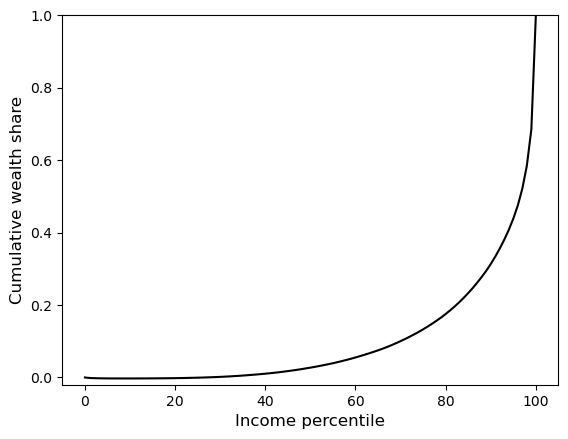

Estimate is center=1.037865204159259, spread=0.0
Lorenz distance is 39.8217250255979
Average MPC for all consumers is 0.168
Average MPC in the top percentile of W/Y is 0.137
Average MPC in the top decile of W/Y is 0.139
Average MPC in the top quintile of W/Y is 0.139
Average MPC in the second quintile of W/Y is 0.141
Average MPC in the middle quintile of W/Y is 0.142
Average MPC in the fourth quintile of W/Y is 0.145
Average MPC in the bottom quintile of W/Y is 0.272
Average MPC in the top percentile of y is 0.143
Average MPC in the top decile of y is 0.146
Average MPC in the top quintile of y is 0.153
Average MPC in the second quintile of y is 0.186
Average MPC in the middle quintile of y is 0.188
Average MPC in the fourth quintile of y is 0.151
Average MPC in the bottom quintile of y is 0.161
Average MPC for the employed is 0.165
Average MPC for the unemployed is 0.200
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
69.689% are in the bottom wealth q

In [22]:
EstimationEconomy = estimate(options, parameters)

In [23]:
# See what the market resources look like for the original specification where GIC is clearly violated

EstimationEconomy.agents[0].solve()
EstimationEconomy.agents[0].track_vars = ["mNrm"]
EstimationEconomy.agents[0].initialize_sim()
EstimationEconomy.agents[0].simulate()


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


{'mNrm': array([[1.00001007, 1.00001007, 1.00001074, ..., 1.00000955, 1.00000955,
         1.0000104 ],
        [1.37895455, 1.41910914, 1.17583348, ..., 1.18357525, 1.3789542 ,
         1.27348809],
        [1.5252344 , 1.53219887, 1.7259651 , ..., 1.3265792 , 1.90881786,
         1.62396947],
        ...,
        [4.62324957, 3.23010104, 8.50662694, ..., 4.51027873, 7.63866817,
         2.71484958],
        [4.4567162 , 3.19063679, 8.36733447, ..., 4.35300486, 7.77382632,
         2.85816793],
        [4.82520367, 3.6478396 , 8.90517092, ..., 4.4886614 , 7.35099278,
         3.3425459 ]])}

In [24]:
EstimationEconomy.agents[0].solution[0].__dict__

{'cFunc': <HARK.interpolation.LowerEnvelope at 0x16272a7c0>,
 'vFunc': <HARK.utilities.NullFunc at 0x168565d60>,
 'vPfunc': <HARK.interpolation.MargValueFuncCRRA at 0x168388490>,
 'vPPfunc': <HARK.utilities.NullFunc at 0x1685658e0>,
 'mNrmMin': 0.0,
 'hNrm': 26.40880759112833,
 'MPCmin': 0.03606348865838198,
 'MPCmax': 1.0,
 'mNrmTrg': None}

### 3. Potential explanations for discrepancy between theory and code

1. Tolerance specified for the solution/simulation
2. Ad-hoc implementation that kills off agents after some number of periods



### 3.1 - Killing off agents

In [25]:
print(f"T_age: {EstimationEconomy.agents[0].T_age}")

T_age: 400


In [26]:
EstimationEconomy.agents[0].T_age = None
print(f"T_age: {EstimationEconomy.agents[0].T_age}")

T_age: None


In [27]:
EstimationEconomy.agents[0].solve()
EstimationEconomy.agents[0].track_vars = ["mNrm"]
EstimationEconomy.agents[0].initialize_sim()
EstimationEconomy.agents[0].simulate()


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


{'mNrm': array([[1.00001007, 1.00001007, 1.00001074, ..., 1.00000955, 1.00000955,
         1.0000104 ],
        [1.37895455, 1.41910914, 1.17583348, ..., 1.18357525, 1.3789542 ,
         1.27348809],
        [1.5252344 , 1.53219887, 1.7259651 , ..., 1.3265792 , 1.90881786,
         1.62396947],
        ...,
        [2.51295541, 5.663092  , 5.31668438, ..., 3.32527825, 7.9398917 ,
         4.4941703 ],
        [2.42269014, 5.54616864, 5.79442149, ..., 3.54265938, 8.41798377,
         4.63374745],
        [2.96276755, 5.94940568, 5.03593917, ..., 3.91146021, 8.69303118,
         4.65153855]])}

In [28]:
EstimationEconomy.agents[0].solution[0].__dict__

{'cFunc': <HARK.interpolation.LowerEnvelope at 0x1621ce970>,
 'vFunc': <HARK.utilities.NullFunc at 0x1685a1a90>,
 'vPfunc': <HARK.interpolation.MargValueFuncCRRA at 0x168596d00>,
 'vPPfunc': <HARK.utilities.NullFunc at 0x1685a1cd0>,
 'mNrmMin': 0.0,
 'hNrm': 26.40880759112833,
 'MPCmin': 0.03606348865838198,
 'MPCmax': 1.0,
 'mNrmTrg': None}

### 3.2 - Tolerance

Note that adjusting the "T_age" attribute to "=None" seems to have made the tracked normalized values of market resources larger than when the attribute is set to "400".

From here, we want to know if there is a difference when the tolerance is set to twice as tight: from "1e-6" to "1e-12".

In [29]:
print(f"Tolerance: {EstimationEconomy.agents[0].tolerance}")

Tolerance: 1e-06


In [30]:
EstimationEconomy.agents[0].tolerance = .000000000001
print(f"Tolerance: {EstimationEconomy.agents[0].tolerance}")

Tolerance: 1e-12


In [31]:
EstimationEconomy.agents[0].solve()
EstimationEconomy.agents[0].track_vars = ["mNrm"]
EstimationEconomy.agents[0].initialize_sim()
EstimationEconomy.agents[0].simulate()

GPFRaw                 = 1.006729 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


{'mNrm': array([[1.00001007, 1.00001007, 1.00001074, ..., 1.00000955, 1.00000955,
         1.0000104 ],
        [1.37895608, 1.41911096, 1.17583515, ..., 1.18357697, 1.37895573,
         1.27348971],
        [1.52523953, 1.53220415, 1.72596851, ..., 1.32658311, 1.90882242,
         1.62397361],
        ...,
        [2.51302807, 5.66347173, 5.31701626, ..., 3.32541891, 7.94069281,
         4.49432668],
        [2.42276291, 5.54656116, 5.7947655 , ..., 3.54281347, 8.41880028,
         4.63390979],
        [2.9628492 , 5.94982408, 5.03629612, ..., 3.91163817, 8.69389066,
         4.65170682]])}

In [32]:
EstimationEconomy.agents[0].solution[0].__dict__

{'cFunc': <HARK.interpolation.LowerEnvelope at 0x168388ac0>,
 'vFunc': <HARK.utilities.NullFunc at 0x168596ac0>,
 'vPfunc': <HARK.interpolation.MargValueFuncCRRA at 0x1625e3d90>,
 'vPPfunc': <HARK.utilities.NullFunc at 0x168565be0>,
 'mNrmMin': 0.0,
 'hNrm': 26.40947070490924,
 'MPCmin': 0.03606250000095809,
 'MPCmax': 1.0,
 'mNrmTrg': None}

Key: Making the "tolerance" twice as small did not change the relevant values of the simulation by much. This suggests that it is less important in explaining the discrepancy between the theory and the numerical implementation, at least when compared to the effect that "T_age" had.

### 4. Modifying the single agent type so that Rfree is right at the cusp.

* GIC is violated; mNrmTrg and mNrmStE both exist and are finite when each should approach infinity
* Note that these values are computed with the modified "T_age" and "tolerance" attributes

In [33]:
EstimationEconomy.agents[0].Rfree = R_cusp_raw
print(R_cusp_raw)
print(EstimationEconomy.agents[0].Rfree)

1.0309278350515465
1.0309278350515465


In [34]:
EstimationEconomy.agents[0].solve()
EstimationEconomy.agents[0].track_vars = ["mNrm"]
EstimationEconomy.agents[0].initialize_sim()
EstimationEconomy.agents[0].simulate()


GPFRaw                 = 1.000000 
GPFNrm                 = 1.003266 
GPFAggLivPrb           = 0.993750 
Thorn = APF            = 1.000000 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.966842 
DiscFacGPFAggLivPrbMax = 0.976101 


{'mNrm': array([[1.00001   , 1.00001   , 1.00001066, ..., 1.00000949, 1.00000949,
         1.00001033],
        [1.35744893, 1.39364816, 1.15242514, ..., 1.15940436, 1.35744864,
         1.25081899],
        [1.45656747, 1.46171395, 1.6807039 , ..., 1.27429896, 1.8476806 ,
         1.56814444],
        ...,
        [1.84504447, 3.08202694, 2.72932712, ..., 2.00761503, 2.43553005,
         2.77267703],
        [1.7643761 , 2.85286072, 3.10949323, ..., 2.12418289, 2.83008496,
         2.86950985],
        [2.23989607, 3.06152849, 2.23781027, ..., 2.29805569, 2.8167081 ,
         2.8414824 ]])}

In [37]:
EstimationEconomy.agents[0].solution[0].__dict__

{'cFunc': <HARK.interpolation.LowerEnvelope at 0x16273dcd0>,
 'vFunc': <HARK.utilities.NullFunc at 0x1685a1a00>,
 'vPfunc': <HARK.interpolation.MargValueFuncCRRA at 0x1627a8dc0>,
 'vPPfunc': <HARK.utilities.NullFunc at 0x1685a17c0>,
 'mNrmMin': 0.0,
 'hNrm': 32.33333323546369,
 'MPCmin': 0.03606250000185602,
 'MPCmax': 1.0,
 'mNrmStE': 2.54816900328363,
 'mNrmTrg': 2.6561395463241344}

### 5. Check how mNrmTrg and mNrmSTE are computed, after these changes have been tried

1. How are mNrmTrg and mNrmSTE computed?
2. If both GPF and GPFNrm are $\geq$ 1 when the agent has "R" set to be the cusp value, then GIC and GICNrm should both be false. Further, mNrmTrg and mNrmSTE are only to be computed when GIC and GICNrm are set to True, i.e. equal to 1. 
    * So then, why are the cusp R value are mNrmTrg and mNrmSTE being computed as finite values? This suggests that there is some discrepancy between the model/code knowing when these conditions are being violated and/or when to compute these values given the violation of the conditions.
        * For the latter, perhaps it is the case that the code doesn't recognize the GPFRaw as being close enough to 1.

3. The theory says the target level of normalized market resources exists when GICNrm holds, however, the code implementation seems to compute mNrmTrg based on the GICRaw condition holding. 